# Neural network from scratch

This notebook is a part of the series __From Scratch__, where i try to code machine learning algorithms from scratch (just numpy and math)

This is a major milestone during my self-taught machine learning journey. Understanding the backpropagation and calculus in it is quite an experience. That said, this is really the simplest implementation :p.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.activations import linear, relu
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import tensorflow as tf
from tqdm import tqdm

### Objective: Determine a tumor's malignancy given its texture_mean and radius_mean

#### The dataset

In [68]:
raw_load = load_breast_cancer(return_X_y=True, as_frame=True)
raw_load[0].head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


#### Test train split

In [69]:
raw_X = raw_load[0].values
raw_y = raw_load[1].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.2)

#### Dimensionality reduction
I deliberately pick 2 as the number of components to reduce the complexity of the Neural Network :p

In [70]:
preprocess = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

#### Scatter plot of the data

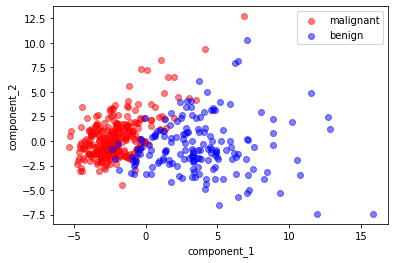

In [71]:
fig, ax = plt.subplots()
combined = np.hstack((X_train, y_train))
mal = combined[combined[:, 2]==1]
ben = combined[combined[:, 2]==0]

ax.scatter(mal[:, 0], mal[:, 1], label="malignant", c="r", alpha=0.5)
ax.scatter(ben[:, 0], ben[:, 1], label="benign", c="b", alpha=0.5)
ax.set_xlabel("component_1")
ax.set_ylabel("component_2")
ax.legend()

plt.show()


### Final dimensions of test and train

In [72]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (455, 2)
Y_train: (455, 1)
X_test:  (114, 2)
Y_test:  (114, 1)


### The Model overview

![alt text](model_nn_scratch.jpg "overview")

## Doing it the "easy" way using keras sequential API

In [73]:
model = Sequential([
    
    Dense(units=2, activation=relu),
    Dense(units=1, activation=linear)
])

model.compile(loss=BinaryCrossentropy(from_logits=True),  # to avoid numerical instability
              optimizer=Adam(learning_rate=0.01),
              metrics="accuracy"
             )
model.fit(X_train, y_train, epochs=80, verbose=0)  # verbose = 0 to avoid printing too much

### Evaluation

In [74]:
result = model.evaluate(X_test, y_test)
print(f"total cost: {result[0]:.3f}")
print(f"accuracy: {result[1]:.3f}")

4/4 [==============================] - 0s 3ms/step - loss: 0.0594 - accuracy: 0.9825
total cost: 0.059
accuracy: 0.982


# Doing it the hard way (from scratch)
Let's start with the math behind neural network

#### The specified architecture
2 features --> 1 hidden layer (2 neuron relu) --> 1 output layer (1 neuron sigmoid)

#### Notation
$z_{1}^{[1]} =$ linear combination of input (feature) to the first neuron of the first layer <br>
$z_{2}^{[1]} =$ linear combination of input (feature) to the second neuron of the first layer <br>

$a_{1}^{[1]} =$ output of the first neuron of the first layer<br>
$a_{2}^{[1]} =$ output of the second neuron of the first layer<br>

$z^{[2]} =$ linear combination of output of the first layer<br>
$a^{[2]} =$ output of the only neuron of the second layer (final output)<br>

name for each parameters can be seen on the model overview above

#### Forward propagation:

$$z_{1}^{[1]} = w_{1}^{[1]}x_{1} + w_{2}^{[1]}x_{2} + b_{1}^{[1]} $$ <br>
$$z_{2}^{[1]} = w_{3}^{[1]}x_{1} + w_{4}^{[1]}x_{2} + b_{2}^{[1]} $$ <br>
$$a_{1}^{[1]} = \text{relu}(z_{1}^{[1]})$$ <br>
$$a_{2}^{[1]} = \text{relu}(z_{2}^{[1]})$$ <br>
$$z^{[2]} = w_{1}^{[2]}x_{1} + w_{2}^{[2]}x_{2} + b^{[2]} $$ <br>
$$a^{[2]} = \frac{1}{1 + e^{-z^{[2]}}}$$ <br>

#### cost & loss function: <br>
$$\text{cross entropy cost}(\hat{a}^{[2]}, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{m}y_{ij}\text{log}(a^{[2]}[ij]) \space\text{where n=number of examples, m=number of class}$$ <br>
$$\text{binary cross entropy cost}(\hat{a}^{[2]}, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n}y_{i}\text{log}(a^{[2]}[i]) + (1-y_{i})\text{log}(1-a^{[2]}[i])$$ <br>

#####  Derivative of cost function w.r.t parameters
$$\frac{\partial ( \text{binary cross entropy cost}(\vec{a}^{[2]}, \vec{y}))}{\partial \vec{w}} = \frac{1}{n}(\frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{1}}{\partial \vec{w}} + \frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{2}}{\partial \vec{w}}+ ...+ \frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{n}}{\partial \vec{w}})\space \text{for n=number of examples}$$<br>

$$\text{binary cross entropy loss}(a^{[2]}, \hat{y}) = -(y_{i}\text{log}(a^{[2]}) + (1-y_{i})\text{log}(1-a^{[2]}))$$

- Intuitively speaking, the gradient of cost function wrt to parameter $w$ is the average of all the gradient of loss function wrt to parameter $w_{1}, w_{2},..., w_{n}$ where $n=$number of examples.


#### Backward propagation:
- The point of backpropagation is to determine the gradient of cost function wrt to each parameter $w$
- Backpropagation involves the derivation of loss function wrt to each parameters, then averaging them later for gradient descent

##### output layer
$\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}}=\frac{\partial a^{[2]}}{\partial z^{[2]}}\times\frac{\partial\text{cost}(a^{[2]})}{\partial a^{[2]}} = (1-a^{[2]})\times \frac{a^{[2]}-y}{a^{[2]}(1-a^{[2]})} = a^{[2]} - y$


$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{1}^{[2]}} = \frac{\partial z^{[2]}}{\partial w_{1}^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a_{1}^{[1]}\times (a^{[2]} - y)$$

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{2}^{[2]}} = \frac{\partial z^{[2]}}{\partial w_{2}^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a_{2}^{[1]}\times (a^{[2]} - y)$$

$$\frac{\partial\text{cost}(a^{[2]})}{\partial b^{[2]}} = \frac{\partial z^{[2]}}{\partial b^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a^{[2]} - y$$


##### hidden layer
$\frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}}=\frac{\partial a_{1}^{[1]}}{\partial z_{1}^{[1]}}\times\frac{\partial z^{[2]}}{\partial a_{1}^{[1]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$ <br>

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{1}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{1}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_1\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$
$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{2}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{2}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_2\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
$$\frac{\partial\text{cost}(a^{[2]})}{\partial b_{1}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial b_{1}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
<br>

$\frac{\partial \text{cost}(a^{[2]})}{\partial z_{2}^{[1]}}=\frac{\partial a_{1}^{[1]}}{\partial z_{2}^{[1]}}\times\frac{\partial z^{[2]}}{\partial a_{1}^{[1]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = \text{relu'}(z_2^{[1]}) \times w_2^{[2]}\times (a^{[2]} - y)$ <br>

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{3}^{[1]}} = \frac{\partial z_{2}^{[1]}}{\partial w_{3}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_1\times \text{relu'}(z_2^{[1]}) \times w_2^{[2]}\times (a^{[2]} - y)$$
$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{4}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{4}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_2\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
$$\frac{\partial\text{cost}(a^{[2]})}{\partial b_{2}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial b_{2}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
<br>

### No vectorization (just for loop), vanilla gradient descent, and non-modular implementation

This implementation is tailored for learning, hence not for production usage. It is meant to be explicit and not use any vectorization. It is also non-modular, as it can only be of the specified architecture and parameters.

In [75]:
class NeuralNetwork():
    
    def initialize(self):
        self.w11, self.w12, self.w13, self.w14, self.w21, self.w22, self.b11, self.b12, self.b2 = np.random.randn(9)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def binary_cross_entropy(self, x, y_true):
        return -(y_true * np.log(x) + (1 - y_true) * np.log(1 - x))
    
    def derivative_relu(self, x):
        return 1 if x>0 else 0
    
    def forward_prop(self, x1, x2):
        forward_dict = {} 
        
        # hidden layer
        forward_dict["z11"] = self.w11 * x1 + self.w12 * x2 + self.b11
        forward_dict["z12"] = self.w13 * x1 + self.w14 * x2 + self.b12
        forward_dict["a11"] = self.relu(forward_dict["z11"])
        forward_dict["a12"] = self.relu(forward_dict["z12"])
        
        # output layer
        forward_dict["z2"] = self.w21 * forward_dict["a11"] + self.w22 * forward_dict["a12"] + self.b2
        forward_dict["a2"] = self.sigmoid(forward_dict["z2"])
        
        return forward_dict

    def back_prop(self, x1, x2, y_true, forward_dict):
        # gradient will be calculated for each training example and averaged later#
        
        deriva_dict = {}
        
        # output layer
        error = forward_dict["a2"] - y_true
        
        deriva_dict["dloss_dw21"] = forward_dict["a11"] * error
        deriva_dict["dloss_dw22"] = forward_dict["a12"] * error
        deriva_dict["dloss_db2"] = error
        
        # hidden layer
        dcost_dz11 = self.derivative_relu(forward_dict["z11"]) * self.w21 * error
        dcost_dz12 = self.derivative_relu(forward_dict["z12"]) * self.w22 * error
        
        deriva_dict["dloss_dw11"] = x1 * dcost_dz11
        deriva_dict["dloss_dw12"] = x2 * dcost_dz11
        deriva_dict["dloss_db11"] = dcost_dz11
        
        deriva_dict["dloss_dw13"] = x1 * dcost_dz12
        deriva_dict["dloss_dw14"] = x2 * dcost_dz12
        deriva_dict["dloss_db12"] = dcost_dz12
        
        return deriva_dict
    
    def get_prob_class(self, x1, x2):
        prob = self.forward_prop(x1, x2)["a2"]
        class_ = self.encode_class(prob)
        return prob, class_
    
    def encode_class(self, x):
        return 1 if x>0.5 else 0
    
    def get_accuracy_cost(self, X, y):
        n = X.shape[0]
        n_correct = 0
        cost = 0
        for i in range(n):
            x1, x2 = X[i]
            prediction = self.get_prob_class(x1, x2)
            if prediction[1] == y[i][0]:
                n_correct += 1
            cost += self.binary_cross_entropy(prediction[0], y[i][0])
        return n_correct/n, cost/n

    def fit(self, X, y, alpha, epochs):
        n, m = X.shape
        
        self.initialize()
        costs = []

        for i in range(1, epochs+1):
            # Loop to iterate based on specified epoch
            
            dcost_dw21 = 0
            dcost_dw22 = 0
            dcost_db2 = 0
            dcost_dw11 = 0
            dcost_dw12 = 0
            dcost_db11 = 0
            dcost_dw13 = 0
            dcost_dw14 = 0
            dcost_db12 = 0
            
            for j in range(n):
                # Loop to find derivatives for each example
                
                x1 , x2 = X[j]
                y_true = y[j][0]
                forward_prop = self.forward_prop(x1, x2)
                back_prop = self.back_prop(x1, x2, y_true, forward_prop)
                
                dcost_dw21 += back_prop["dloss_dw21"]
                dcost_dw22 += back_prop["dloss_dw22"]
                dcost_db2 += back_prop["dloss_db2"]
                dcost_dw11 += back_prop["dloss_dw11"]
                dcost_dw12 += back_prop["dloss_dw12"]
                dcost_db11 += back_prop["dloss_db11"]
                dcost_dw13 += back_prop["dloss_dw13"]
                dcost_dw14 += back_prop["dloss_dw14"]
                dcost_db12 += back_prop["dloss_db12"]
            
            # The parameter update process
            self.w21 -= alpha*(1/n)*dcost_dw21 
            self.w22 -= alpha*(1/n)*dcost_dw22 
            self.b2  -= alpha*(1/n)*dcost_db2
            self.w11 -= alpha*(1/n)*dcost_dw11 
            self.w12 -= alpha*(1/n)*dcost_dw12 
            self.b11 -= alpha*(1/n)*dcost_db11
            self.w13 -= alpha*(1/n)*dcost_dw13
            self.w14 -= alpha*(1/n)*dcost_dw14
            self.b12 -= alpha*(1/n)*dcost_db12
            
            accuracy, cost = self.get_accuracy_cost(X, y)
            costs.append(cost)
            
            print(f"epoch: {i}, cost: {cost:.4f}, accuracy: {accuracy*100:.2f}%")

### Training

In [76]:
classifier = NeuralNetwork()
classifier.fit(X_train, y_train, 0.1, 200)

epoch: 1, cost: 1.6640, accuracy: 21.10%
epoch: 2, cost: 1.1853, accuracy: 22.20%
epoch: 3, cost: 0.8256, accuracy: 26.59%
epoch: 4, cost: 0.6817, accuracy: 37.58%
epoch: 5, cost: 0.6716, accuracy: 38.02%
epoch: 6, cost: 0.6649, accuracy: 38.02%
epoch: 7, cost: 0.6585, accuracy: 38.90%
epoch: 8, cost: 0.6523, accuracy: 39.56%
epoch: 9, cost: 0.6462, accuracy: 40.00%
epoch: 10, cost: 0.6402, accuracy: 41.10%
epoch: 11, cost: 0.6343, accuracy: 41.10%
epoch: 12, cost: 0.6284, accuracy: 41.32%
epoch: 13, cost: 0.6227, accuracy: 41.54%
epoch: 14, cost: 0.6170, accuracy: 83.52%
epoch: 15, cost: 0.6114, accuracy: 83.30%
epoch: 16, cost: 0.6059, accuracy: 83.52%
epoch: 17, cost: 0.6004, accuracy: 83.52%
epoch: 18, cost: 0.5951, accuracy: 83.52%
epoch: 19, cost: 0.5898, accuracy: 83.52%
epoch: 20, cost: 0.5845, accuracy: 83.74%
epoch: 21, cost: 0.5794, accuracy: 83.74%
epoch: 22, cost: 0.5743, accuracy: 83.96%
epoch: 23, cost: 0.5692, accuracy: 84.40%
epoch: 24, cost: 0.5643, accuracy: 84.40%
e

epoch: 198, cost: 0.2952, accuracy: 89.01%
epoch: 199, cost: 0.2948, accuracy: 89.01%
epoch: 200, cost: 0.2945, accuracy: 89.01%


### Evaluation

In [77]:
result = classifier.get_accuracy_cost(X_test, y_test)

print(f"cost: {result[1]:.3f}")
print(f"accuracy: {result[0]:.3f}")

cost: 0.247
accuracy: 0.921


## Bonus: Vanilla gradient descent vs mini batch gradient descent

The following is the same neural network with the same architecture but with mini batch gradient descent instead of vanilla gradient descent

In [78]:
class NeuralNetwork_batch():
    
    def initialize(self):
        self.w11, self.w12, self.w13, self.w14, self.w21, self.w22, self.b11, self.b12, self.b2 = np.random.randn(9)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def binary_cross_entropy(self, x, y_true):
        return -(y_true * np.log(x) + (1 - y_true) * np.log(1 - x))
    
    def derivative_relu(self, x):
        return 1 if x>0 else 0
    
    def forward_prop(self, x1, x2):
        forward_dict = {} 
        
        # hidden layer
        forward_dict["z11"] = self.w11 * x1 + self.w12 * x2 + self.b11
        forward_dict["z12"] = self.w13 * x1 + self.w14 * x2 + self.b12
        forward_dict["a11"] = self.relu(forward_dict["z11"])
        forward_dict["a12"] = self.relu(forward_dict["z12"])
        
        # output layer
        forward_dict["z2"] = self.w21 * forward_dict["a11"] + self.w22 * forward_dict["a12"] + self.b2
        forward_dict["a2"] = self.sigmoid(forward_dict["z2"])
        
        return forward_dict

    def back_prop(self, x1, x2, y_true, forward_dict):
        # gradient will be calculated for each training example and averaged later#
        
        deriva_dict = {}
        
        # output layer
        error = forward_dict["a2"] - y_true
        
        deriva_dict["dloss_dw21"] = forward_dict["a11"] * error
        deriva_dict["dloss_dw22"] = forward_dict["a12"] * error
        deriva_dict["dloss_db2"] = error
        
        # hidden layer
        dcost_dz11 = self.derivative_relu(forward_dict["z11"]) * self.w21 * error
        dcost_dz12 = self.derivative_relu(forward_dict["z12"]) * self.w22 * error
        
        deriva_dict["dloss_dw11"] = x1 * dcost_dz11
        deriva_dict["dloss_dw12"] = x2 * dcost_dz11
        deriva_dict["dloss_db11"] = dcost_dz11
        
        deriva_dict["dloss_dw13"] = x1 * dcost_dz12
        deriva_dict["dloss_dw14"] = x2 * dcost_dz12
        deriva_dict["dloss_db12"] = dcost_dz12
        
        return deriva_dict
    
    def get_prob_class(self, x1, x2):
        prob = self.forward_prop(x1, x2)["a2"]
        class_ = self.encode_class(prob)
        return prob, class_
    
    def encode_class(self, x):
        return 1 if x>0.5 else 0
    
    def get_accuracy_cost(self, X, y):
        n = X.shape[0]
        n_correct = 0
        cost_total = 0
        for i in range(n):
            x1, x2 = X[i]
            prediction = self.get_prob_class(x1, x2)
            if prediction[1] == y[i][0]:
                n_correct += 1
            cost_total += self.binary_cross_entropy(prediction[0], y[i][0])
        return n_correct/n, cost_total/n

    def fit(self, X, y, alpha, epochs, batch_size=32):
        n, m = X.shape
        combined = np.hstack([X, y])
        self.initialize()
        n_iter_batch = np.ceil(n/batch_size)  # Number of training iteration for one epoch
        

        for i in range(1, epochs+1):
            dcost_dw21 = 0
            dcost_dw22 = 0
            dcost_db2 = 0
            dcost_dw11 = 0
            dcost_dw12 = 0
            dcost_db11 = 0
            dcost_dw13 = 0
            dcost_dw14 = 0
            dcost_db12 = 0
            
            #Shuffled the dataset before splitting
            combined_shuffled = np.random.permutation(combined)
            X_shuffled = combined_shuffled[:, 0:-1]
            y_shuffled = combined_shuffled[:, -1].reshape(-1, 1)
            
            costs_batch = 0
            accuracies_batch = 0
            for k in tqdm(range(0, n, batch_size), position=0):
                X_batch = X_shuffled[k: k+batch_size]
                y_batch = y_shuffled[k: k+batch_size]
                n_batch = X_batch.shape[0]
            
                for j in range(n_batch):
                    x1 , x2 = X_batch[j]
                    y_true = y_batch[j][0]
                    forward_prop = self.forward_prop(x1, x2)
                    back_prop = self.back_prop(x1, x2, y_true, forward_prop)

                    dcost_dw21 += back_prop["dloss_dw21"]
                    dcost_dw22 += back_prop["dloss_dw22"]
                    dcost_db2 += back_prop["dloss_db2"]
                    dcost_dw11 += back_prop["dloss_dw11"]
                    dcost_dw12 += back_prop["dloss_dw12"]
                    dcost_db11 += back_prop["dloss_db11"]
                    dcost_dw13 += back_prop["dloss_dw13"]
                    dcost_dw14 += back_prop["dloss_dw14"]
                    dcost_db12 += back_prop["dloss_db12"]

                self.w21 -= alpha*(1/n)*dcost_dw21 
                self.w22 -= alpha*(1/n)*dcost_dw22 
                self.b2  -= alpha*(1/n)*dcost_db2
                self.w11 -= alpha*(1/n)*dcost_dw11 
                self.w12 -= alpha*(1/n)*dcost_dw12 
                self.b11 -= alpha*(1/n)*dcost_db11
                self.w13 -= alpha*(1/n)*dcost_dw13
                self.w14 -= alpha*(1/n)*dcost_dw14
                self.b12 -= alpha*(1/n)*dcost_db12

                accuracy, cost = self.get_accuracy_cost(X_batch, y_batch)
                costs_batch += cost
                accuracies_batch += accuracy
            
            # Reported cost and accuracy are averaged across the mini batch
            # of a given epoch
            epoch_cost = costs_batch/n_iter_batch
            epoch_accuracy = accuracies_batch/n_iter_batch
            print(f"epoch: {i}, cost: {epoch_cost:.4f}, accuracy: {epoch_accuracy:.2f}%")

### Training using small epoch (30)

#### With mini batch

In [79]:
classifier_batch = NeuralNetwork_batch()
classifier_batch.fit(X_train, y_train, 0.1, 30)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.65it/s]


epoch: 1, cost: 0.5522, accuracy: 0.68%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 256.43it/s]


epoch: 2, cost: 0.3144, accuracy: 0.92%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 203.75it/s]


epoch: 3, cost: 0.2553, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.54it/s]


epoch: 4, cost: 0.2363, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.85it/s]


epoch: 5, cost: 0.2295, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 270.96it/s]


epoch: 6, cost: 0.2264, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 323.94it/s]


epoch: 7, cost: 0.2235, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.34it/s]


epoch: 8, cost: 0.2137, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.03it/s]


epoch: 9, cost: 0.2182, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.16it/s]


epoch: 10, cost: 0.2168, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.76it/s]


epoch: 11, cost: 0.2237, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.71it/s]


epoch: 12, cost: 0.1982, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.22it/s]


epoch: 13, cost: 0.2284, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.69it/s]


epoch: 14, cost: 0.1985, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.47it/s]


epoch: 15, cost: 0.1973, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 244.74it/s]


epoch: 16, cost: 0.2020, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.44it/s]


epoch: 17, cost: 0.1994, accuracy: 0.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.91it/s]


epoch: 18, cost: 0.1865, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.48it/s]


epoch: 19, cost: 0.1857, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.89it/s]


epoch: 20, cost: 0.1844, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 232.01it/s]


epoch: 21, cost: 0.1889, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 245.33it/s]


epoch: 22, cost: 0.1861, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.78it/s]


epoch: 23, cost: 0.1806, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.47it/s]


epoch: 24, cost: 0.2016, accuracy: 0.93%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 228.26it/s]


epoch: 25, cost: 0.1766, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.77it/s]


epoch: 26, cost: 0.1731, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 276.47it/s]


epoch: 27, cost: 0.1710, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 267.22it/s]


epoch: 28, cost: 0.1866, accuracy: 0.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 238.28it/s]


epoch: 29, cost: 0.1748, accuracy: 0.96%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 206.05it/s]

epoch: 30, cost: 0.1683, accuracy: 0.96%


#### Without mini batch

In [81]:
classifier = NeuralNetwork()
classifier.fit(X_train, y_train, 0.1, 30)

epoch: 1, cost: 1.3219, accuracy: 25.49%
epoch: 2, cost: 0.9042, accuracy: 49.45%
epoch: 3, cost: 0.7690, accuracy: 61.98%
epoch: 4, cost: 0.7222, accuracy: 62.86%
epoch: 5, cost: 0.6971, accuracy: 62.86%
epoch: 6, cost: 0.6795, accuracy: 62.86%
epoch: 7, cost: 0.6652, accuracy: 62.86%
epoch: 8, cost: 0.6528, accuracy: 62.86%
epoch: 9, cost: 0.6416, accuracy: 62.86%
epoch: 10, cost: 0.6311, accuracy: 62.86%
epoch: 11, cost: 0.6211, accuracy: 62.86%
epoch: 12, cost: 0.6115, accuracy: 62.86%
epoch: 13, cost: 0.6024, accuracy: 62.86%
epoch: 14, cost: 0.5936, accuracy: 62.86%
epoch: 15, cost: 0.5854, accuracy: 62.86%
epoch: 16, cost: 0.5773, accuracy: 62.86%
epoch: 17, cost: 0.5694, accuracy: 62.86%
epoch: 18, cost: 0.5617, accuracy: 62.86%
epoch: 19, cost: 0.5541, accuracy: 62.86%
epoch: 20, cost: 0.5468, accuracy: 62.86%
epoch: 21, cost: 0.5397, accuracy: 62.86%
epoch: 22, cost: 0.5328, accuracy: 62.86%
epoch: 23, cost: 0.5261, accuracy: 62.86%
epoch: 24, cost: 0.5197, accuracy: 62.86%
e

### Evaluation & Comparison

In [82]:
classifier_ = classifier.get_accuracy_cost(X_test, y_test)

print(f"cost without minibatch: {classifier_[1]:.3f}")
print(f"accuracy without minibatch: {classifier_[0]:.3f}")

classifier_batch_ = classifier_batch.get_accuracy_cost(X_test, y_test)

print(f"cost with minibatch: {classifier_batch_[1]:.3f}")
print(f"accuracy with minibatch: {classifier_batch_[0]:.3f}")

cost without minibatch: 0.414
accuracy without minibatch: 0.623
cost with minibatch: 0.097
accuracy with minibatch: 0.982


It appears that, in the long run, mini batch gradient descent can achieve better metrics using less epoch, hence more efficient

# That's it. not bad at all :p